In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import numpy as np
import axelrod as axl  # https://axelrod.readthedocs.io/en/stable/index.html
from time import time
from pprint import pprint
import matplotlib.pyplot as plt
#from itertools import permutations
#from collections import namedtuple, deque

np.set_printoptions(precision=3)

# the following imports are from network / axl_utils folder
import network
from axl_utils import NNplayer, State, set_match, set_play

In [3]:
C = axl.Action.C
D = axl.Action.D

# config game rules
# set_match & set_play function could be found inside axl_utils/game.py
GAME_LEN = 20 + 1
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

In [4]:
# the play function set up match between 2 players, print the result then return the match object
game = play(axl.Prober4(), axl.TitForTat())
game

[(3, 3), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (1, 1), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (0, 5), (5, 0)]
Player 1 score = 50
Player 2 score = 45


In [5]:
# State class could be found under axl_utils/nnplayer.py

# this is how we define state, in 2d arrays    (3d here for batch training)
# the upper row is the action history of player 1 (usually our DQN)
# lower is its opponent
# '1' represent cooperation
# '0' represent defection
# '-1' means the turn has not happened yet
s = State(GAME_LEN)
s.push(C, D)
print(s.values())

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]]


### Section 1: DQN

In [6]:
# DQN class is inside network/dqn.py
# it defines how the network make decision + how it learns

dqn = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            network.ReplayMemory(2000), gamma=0.9, greedy=0.2)

# NNplayer class is inside axl_utils/nnplayer.py
# it integrates our DQN with the axl library
# to allow it play under axl's environment

p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [7]:
# 'with' statement makes my DQN enter test mode
# where its episilon-greedy is set to 0 (no random exploration)
# + printing our the estimated Q-value

with p1:
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
    
# initial Q_value predictions:

[[ 1.511 -0.936]]
[[ 0.704 -0.422]]
[[ 1.38  -0.825]]
[[ 0.809 -1.205]]
[[-0.194 -0.434]]
[[-0.448 -0.39 ]]
[[-0.412 -1.175]]
[[-0.232 -1.195]]
[[ 0.972 -0.711]]
[[ 0.589 -1.403]]
[[ 1.956 -1.072]]
[[ 1.185 -0.599]]
[[ 1.831 -0.883]]
[[ 1.46  -1.036]]
[[ 0.93  -1.188]]
[[ 2.445 -1.203]]
[[ 2.147 -1.062]]
[[ 2.758 -1.137]]
[[ 3.052 -0.939]]
[[1.882 0.093]]
[[3.461e+00 5.299e-04]]


In [8]:
# initial experience
# high greedy -> more random exploration

p1.set_greedy(0.8)
for i in range(60):
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
p1.set_greedy(0.2)

In [9]:
# theoritical Q values
# assuming the player cooperate til the last turn, then defect
# apply annuity formula with cashflow = 3.0, interest rate = 1/9, periods = 20 turns
# * the (1/9) come from our hyperparameter gamma, which is set to 0.9 by default
# then compensate the defection in 2nd last turn, and hard code the last turn to 0.0
true_Q = np.array([3.0/(1/9) * (1.0 - 1.0/(1.0+1/9)**(19-i)) + 5.0 if i<20 else 0.0 for i in range(21)])
[print(f'{i:.2f}') for i in true_Q];

28.35
27.95
27.50
27.00
26.44
25.82
25.14
24.37
23.53
22.59
21.54
20.38
19.09
17.65
16.06
14.29
12.32
10.13
7.70
5.00
0.00


In [10]:
# training loop

score_ls = []
errors = []
for _ in range(20):
    start = time()
    
    # calling train method bound to NNplayer/DQN class
    # detailed documentation are there
    p1.train(30, param)
    
    # collect new experience with trained network
    [Match((p1, axl.TitForTat())).play() for _ in range(10)]
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # calculating Q-value error for later use
    # a bit tedious here but I'm too lazy to fix
    values = []
    state = State(21)
    for i in range(21):
        value = p1.network(state.values())[0]
        values.append(value[0])
        state.push(C, C)
    error = true_Q - np.array(values)
    errors.append(error)


# left: running loss for cooperation
# right: running loss for defection

loss: [0.231 0.342],            time: +3.17 sec
loss: [0.178 0.184],            time: +3.75 sec
loss: [0.12  0.126],            time: +4.38 sec
loss: [0.089 0.088],            time: +4.61 sec
loss: [0.065 0.06 ],            time: +4.91 sec
loss: [0.055 0.053],            time: +4.80 sec
loss: [0.039 0.041],            time: +4.78 sec
loss: [0.037 0.033],            time: +4.93 sec
loss: [0.033 0.029],            time: +4.62 sec
loss: [0.024 0.023],            time: +4.62 sec
loss: [0.034 0.031],            time: +4.61 sec
loss: [0.022 0.027],            time: +4.59 sec
loss: [0.021 0.025],            time: +4.76 sec
loss: [0.022 0.032],            time: +4.66 sec
loss: [0.023 0.018],            time: +4.65 sec
loss: [0.022 0.019],            time: +4.67 sec
loss: [0.016 0.018],            time: +4.66 sec
loss: [0.016 0.025],            time: +4.64 sec
loss: [0.013 0.015],            time: +4.86 sec
loss: [0.016 0.019],            time: +4.62 sec


In [11]:
with p1:
    play(p1, axl.TitForTat())
# predicted Q-values after training:

[[26.955 26.297]]
[[26.106 25.486]]
[[25.715 25.134]]
[[25.344 24.651]]
[[24.85  24.186]]
[[24.287 23.63 ]]
[[23.652 22.936]]
[[22.931 22.255]]
[[22.124 21.398]]
[[21.223 20.548]]
[[20.281 19.608]]
[[19.169 18.566]]
[[18.024 17.354]]
[[16.674 16.056]]
[[15.19  14.501]]
[[13.575 12.848]]
[[11.756 11.086]]
[[9.799 9.376]]
[[7.532 5.861]]
[[2.994 5.013]]
[[-0.011  0.015]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


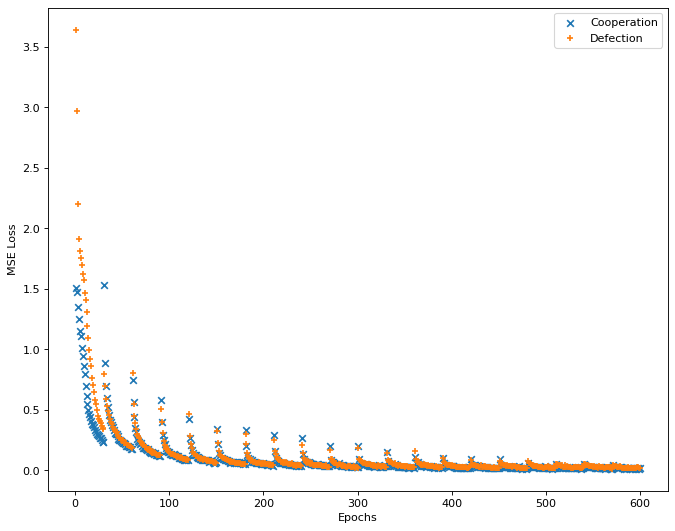

In [12]:
# training loss
# the beauty of double DQN
p1.plot()

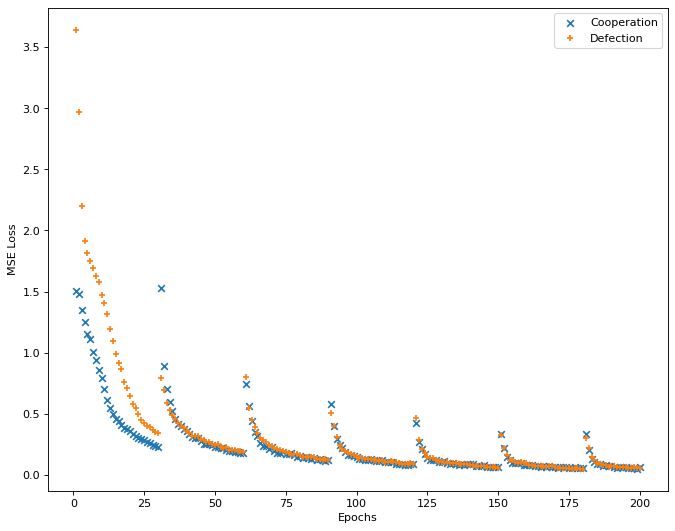

In [13]:
# zoom in first 200 epochs... for fun!
p1.plot(min_ran=0, max_ran=200)

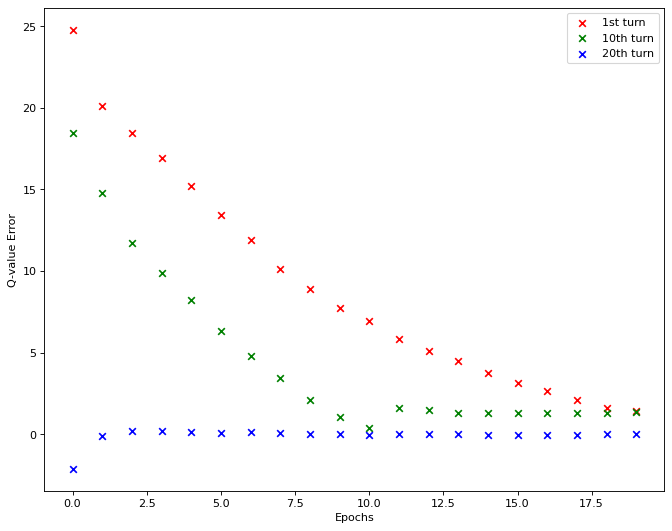

In [14]:
# visualizing the recursion nature of Bellman's equation,
# where the later states has to be learnt prior to learning preceding states

# plotting the error between our prediction against the theoritical Q-value
errors = np.array(errors)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(range(len(errors)), errors[:,0], c='r', marker='x', label='1st turn')
plt.scatter(range(len(errors)), errors[:,9], c='g', marker='x', label='10th turn')
plt.scatter(range(len(errors)), [e[19]-2 for e in errors], c='b', marker='x', label='20th turn')  # compensate for defection
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Q-value Error')
plt.show()

# due to the recursion
# V(current) is dependant on V(next)
# meaning that 1st turn will not be correctly learnt until 2nd got the right value
# resulting in the gaps below

# this is similar to how tabular Q learning works via dynamic programming

### Section 2: DQN without fixed target (single DQN)

In [15]:
dqn2 = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            network.ReplayMemory(2000), gamma=0.9, greedy=0.2)
p2 = NNplayer(dqn2, State(GAME_LEN))
del dqn2
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

p2.set_greedy(0.8)
for i in range(60):
    players = (p2, axl.TitForTat())
    game = Match(players)
    game.play()
p2.set_greedy(0.2)

for _ in range(100):
    start = time()
    
    p2.train(1, param)  # my train function updates target net at the end via deepcopy, we can overwrite this by
    p2.network.target_net = p2.network.policy_net  # shallow copy policy net to target net
    
    [Match((p2, axl.TitForTat())).play() for _ in range(10)]
    print(f'loss: {p2.network.loss},            time: +{time()-start:.2f} sec')

loss: [1.51  3.514],            time: +0.34 sec
loss: [1.972 3.432],            time: +0.34 sec
loss: [2.059 2.848],            time: +0.38 sec
loss: [2.185 2.747],            time: +0.36 sec
loss: [2.285 2.454],            time: +0.39 sec
loss: [2.372 2.624],            time: +0.38 sec
loss: [2.645 2.742],            time: +0.39 sec
loss: [2.813 3.079],            time: +0.38 sec
loss: [3.216 3.378],            time: +0.37 sec
loss: [3.554 3.781],            time: +0.37 sec
loss: [3.945 4.257],            time: +0.37 sec
loss: [4.383 4.886],            time: +0.38 sec
loss: [5.042 5.765],            time: +0.37 sec
loss: [5.564 6.587],            time: +0.37 sec
loss: [6.324 7.658],            time: +0.38 sec
loss: [6.986 8.813],            time: +0.39 sec
loss: [8.163 9.875],            time: +0.38 sec
loss: [ 9.299 10.708],            time: +0.37 sec
loss: [10.364 12.08 ],            time: +0.38 sec
loss: [11.87 13.17],            time: +0.38 sec
loss: [12.672 13.405],            ti

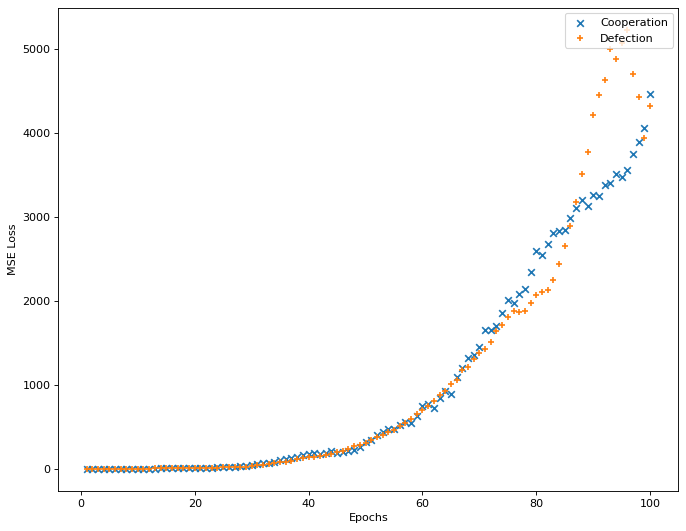

In [16]:
# see how loss grows exponentially without fixed target
p2.plot()

In [17]:
# result:
with p2:
    play(p2, axl.TitForTat())
    
# incorrect Q-values -> bad/random policy
# (run this section serveral time to see how the policy is effectively random)

[[2780.609 1741.922]]
[[8518.04  7414.198]]
[[ -116.303 -1184.296]]
[[3516.549 2199.775]]
[[3318.781 1919.155]]
[[5507.247 3966.481]]
[[ 815.681 -635.327]]
[[6233.829 4576.818]]
[[1242.365 -305.742]]
[[6834.516 5161.826]]
[[ 506.483 -966.064]]
[[6360.957 4792.69 ]]
[[6425.17  4962.641]]
[[1621.369  332.853]]
[[3582.337 2360.319]]
[[ 681.904 -345.433]]
[[1543.85  672.2 ]]
[[975.745 297.994]]
[[1177.599  612.909]]
[[404.185   0.488]]
[[-154.498 -454.127]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
Player 1 score = 60
Player 2 score = 60


In [18]:
del p2

### Section 3: testing the off-policyness

In [19]:
from axl_utils.extract import extract

In [20]:
# collecting experience from axl.Random
memory = network.ReplayMemory(10000)
for _ in range(500):
    game = play(axl.Random(), axl.TitForTat(), show=False)
    extract(game, memory)
    
print(len(memory))
# we can then pass this memory into a fresh DQN

10000


In [21]:
dqn3 = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            memory, gamma=0.9, greedy=0.2)  # <- feeding the memory from axl.Random
p3 = NNplayer(dqn3, State(GAME_LEN))
del dqn3
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [22]:
for _ in range(20):
    start = time()
    p3.train(5, param)
    print(f'loss: {p3.network.loss},            time: +{time()-start:.2f} sec')

loss: [0.317 0.366],            time: +4.12 sec
loss: [0.29  0.279],            time: +4.47 sec
loss: [0.21  0.222],            time: +4.15 sec
loss: [0.159 0.201],            time: +4.23 sec
loss: [0.158 0.156],            time: +4.19 sec
loss: [0.132 0.145],            time: +3.97 sec
loss: [0.123 0.138],            time: +4.00 sec
loss: [0.109 0.118],            time: +3.91 sec
loss: [0.107 0.111],            time: +3.94 sec
loss: [0.102 0.104],            time: +4.05 sec
loss: [0.1   0.103],            time: +3.99 sec
loss: [0.085 0.083],            time: +3.98 sec
loss: [0.083 0.084],            time: +3.92 sec
loss: [0.077 0.075],            time: +3.93 sec
loss: [0.073 0.071],            time: +3.97 sec
loss: [0.071 0.078],            time: +3.93 sec
loss: [0.062 0.065],            time: +3.91 sec
loss: [0.063 0.062],            time: +3.90 sec
loss: [0.056 0.057],            time: +3.87 sec
loss: [0.058 0.057],            time: +3.95 sec


In [23]:
with p3:
    play(p3, axl.TitForTat())
    
# learns well, without ever playing the game

[[26.491 25.881]]
[[25.888 25.273]]
[[25.23  24.587]]
[[24.614 24.022]]
[[24.131 23.505]]
[[23.559 22.814]]
[[22.982 22.31 ]]
[[22.343 21.699]]
[[21.656 20.905]]
[[21.018 20.433]]
[[20.135 19.365]]
[[19.131 18.531]]
[[17.886 17.082]]
[[16.639 16.172]]
[[14.958 14.428]]
[[13.285 12.732]]
[[11.676 11.115]]
[[9.532 8.882]]
[[7.364 5.808]]
[[2.203 4.337]]
[[-0.106  0.144]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


In [24]:
del p3

### Section 4: but what did it learn?

In [25]:
# might be an obvious question but let's see what happens if our DQN meets provocative defection

p1.network.greedy = 0.0
play(p1, axl.HardProber());  # hard prober defects forever if its opponent does not retaliate

[(0, 5), (0, 5), (3, 3), (3, 3), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (1, 1)]
Player 1 score = 7
Player 2 score = 92


In [26]:
play(axl.Cooperator(), axl.HardProber());  # => our DQN is basically a naive cooperator

[(0, 5), (0, 5), (3, 3), (3, 3), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5)]
Player 1 score = 6
Player 2 score = 96


In [27]:
play(axl.TitForTat(), axl.HardProber());  # while TFT can generalize well to any opponent

[(0, 5), (1, 1), (5, 0), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
Player 1 score = 57
Player 2 score = 57


In [28]:
# => continue exploration on Stage 2

### Section 5: learning TFT with 2 perceptrons

In [29]:
# possible states of last turn
# where [1,1] means mutual cooperation
last_turn = np.array([[1,1],[0,1],[1,0],[0,0]])

# target
# => copy opponent's action
action = np.array([[1],[1],[0],[0]])

nn = network.NeuralNetwork([network.Linear_layer(2, 1)])
param = {"lr": 3e-2, 'batch': 2, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [30]:
for i in range(40):
    nn.train(last_turn, action, param)
    action_ = np.round(nn(last_turn))
    accuracy = np.sum(action_==action) / len(action)
    print(f"Epoch {i}, Accuracy = {accuracy}")

Average loss = 1.848310, elapsed time = 0.00.
Epoch 0, Accuracy = 0.5
Average loss = 1.664073, elapsed time = 0.00.
Epoch 1, Accuracy = 0.5
Average loss = 1.437929, elapsed time = 0.00.
Epoch 2, Accuracy = 0.5
Average loss = 1.282943, elapsed time = 0.00.
Epoch 3, Accuracy = 0.5
Average loss = 1.110351, elapsed time = 0.00.
Epoch 4, Accuracy = 0.5
Average loss = 0.968368, elapsed time = 0.00.
Epoch 5, Accuracy = 0.5
Average loss = 0.837737, elapsed time = 0.00.
Epoch 6, Accuracy = 0.25
Average loss = 0.771027, elapsed time = 0.00.
Epoch 7, Accuracy = 0.25
Average loss = 0.640915, elapsed time = 0.00.
Epoch 8, Accuracy = 0.25
Average loss = 0.575231, elapsed time = 0.00.
Epoch 9, Accuracy = 0.25
Average loss = 0.527869, elapsed time = 0.00.
Epoch 10, Accuracy = 0.25
Average loss = 0.474028, elapsed time = 0.00.
Epoch 11, Accuracy = 0.25
Average loss = 0.463023, elapsed time = 0.00.
Epoch 12, Accuracy = 0.25
Average loss = 0.435756, elapsed time = 0.00.
Epoch 13, Accuracy = 0.25
Average 

In [31]:
# but this is more of a policy-gradient approach
# the regression nature of DQNs make it impossible to employ simple architecture